In [1]:
%matplotlib inline

import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy.tensor.array import derive_by_array

import warnings
warnings.filterwarnings("ignore")

In [2]:
x0, x1 = sp.symbols('x0, x1')

In [3]:
def create_lambdas(symbols, f):
    return [
        sp.lambdify(symbols, f), 
        sp.lambdify(symbols, [[t] for t in derive_by_array(f, symbols)]),
        sp.lambdify(symbols, derive_by_array(derive_by_array(f, symbols), symbols)),
    ]

In [4]:
def golden_section_method(fun, a, b, epsilon):
    n = 0
    
    delta = 0.9 * 2 * epsilon
    
    tau = (np.sqrt(5) - 1)/2
    
    x_2 = a + tau*(b-a)
    x_1 = a + b - x_2

    f_x_1 = fun(x_1)
    f_x_2 = fun(x_2)
    
    n = n + 2
    
    while True:
        if f_x_1 <= f_x_2:
            b = x_2
            x_2 = x_1
            f_x_2 = f_x_1
            x_1 = a + b - x_1
            f_x_1 = fun(x_1)
        else:
            a = x_1
            x_1 = x_2
            f_x_1 = f_x_2
            x_2 = a + b - x_2
            f_x_2 = fun(x_2)
        
        n = n + 1
    
        U = (b-a)/2
        
        if U > epsilon:
            continue
        else:
            break
        
    x_min = (a + b)/2
    f_min = fun(x_min)
    
    return {'x_min':x_min, 'f_min':f_min, 'n':n}

In [5]:
def newton_method(f, grad_f, H_f, eps, x, h):
    plt.figure()
    plt.title('newton_method')
    x_grid=np.arange(x[0][0]-h,x[0][0]+h,0.01)
    y_grid=np.arange(x[1][0]-h,x[1][0]+h,0.01)
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)
    z_mesh = f(x_mesh, y_mesh)
    
    plt.pcolormesh(x_mesh,y_mesh,z_mesh, cmap = 'inferno')
    plt.colorbar()

    x0 = [x[0][0]]
    x1 = [x[1][0]]
    
    k = 0
    while True:
        k = k + 1
        p = -np.dot(np.linalg.inv(H_f(x[0][0], x[1][0])), grad_f(x[0][0], x[1][0]))
        x = x + p
        x0.append(x[0][0])
        x1.append(x[1][0])
        
        if (np.linalg.norm(grad_f(x[0][0], x[1][0]))<eps):
            break
    
    plt.plot(x0, x1,'.-')
    plt.plot(x0[0], x1[0], 'ro')
    plt.plot(x0[-1], x1[-1], 'go')
    plt.show()
        
    return f(x[0][0],x[1][0]), x, k

In [6]:
def quasi_newton_method(f, grad_f, A, eps, x, method, h):
    plt.figure()
    plt.title('quasi_newton_method = ' + str(method))
    x_grid=np.arange(x[0][0] - h,x[0][0]+h,0.01)
    y_grid=np.arange(x[1][0] - h,x[1][0]+h,0.01)
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)
    z_mesh = f(x_mesh, y_mesh)
    
    plt.pcolormesh(x_mesh,y_mesh,z_mesh, cmap = 'inferno')
    plt.colorbar()

    x0 = [x[0][0]]
    x1 = [x[1][0]]
    
    alpha = sp.symbols('alpha')
    
    k = 0
    while True:
        k = k + 1
        p = -np.dot(A, grad_f(x[0][0], x[1][0]))
        
        f2 = sp.lambdify(alpha, f(x[0][0] + alpha*p[0][0], x[1][0] + alpha*p[1][0]))

        a = golden_section_method(f2, 0, 1, eps)['x_min']
        
        gk = np.array(grad_f(x[0][0], x[1][0]))
        xk = x
                            
        x = x + np.multiply(a,p)
        x0.append(x[0][0])
        x1.append(x[1][0])
        
        gk_ = np.array(grad_f(x[0][0], x[1][0]))
        xk_ = x
       
        sk = xk_ - xk
        yk = gk_ - gk
        

        if (np.linalg.norm(gk)<eps):
            break
        
        if (method == 1):
            #ДФП
            Q1 = np.dot(sk, sk.T)
            P1 = np.dot(sk.T, yk)
            Q2 = np.dot(A, np.dot(yk, np.dot(yk.T, A)))
            P2 = np.dot(yk.T, np.dot(A, yk))
            A = A + Q1/P1 - Q2/P2
            
        if (method == 2):
            #БФГШ
            Q1 = np.linalg.multi_dot([yk.T, A, yk])
            P1 = np.dot(yk.T,sk)
            Q2 = np.dot(sk, sk.T)
            P2 = np.dot(sk.T, yk)
            Q3 = np.linalg.multi_dot([sk, yk.T, A]) + np.linalg.multi_dot([A, yk, sk.T])
            P3 = np.dot(yk.T, sk)
            A = A + (np.multiply(1 + Q1/P1,Q2/P2) - Q3/P3)

    plt.plot(x0, x1,'.-')
    plt.plot(x0[0], x1[0], 'ro')
    plt.plot(x0[-1], x1[-1], 'go')
    plt.show()
    
    return f(x[0][0], x[1][0]), x, k

# Задание 2

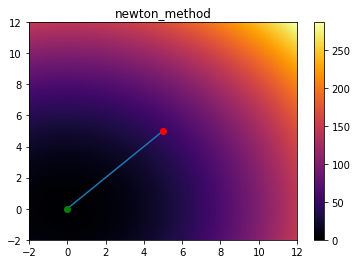

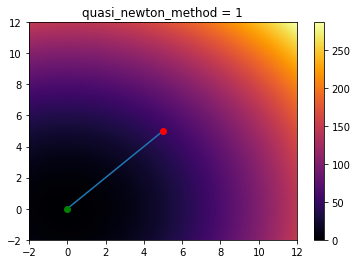

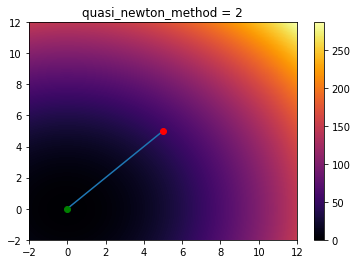

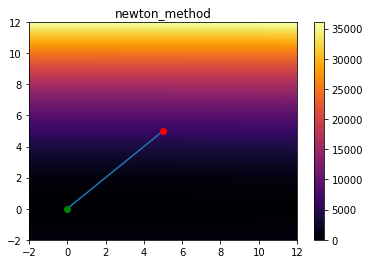

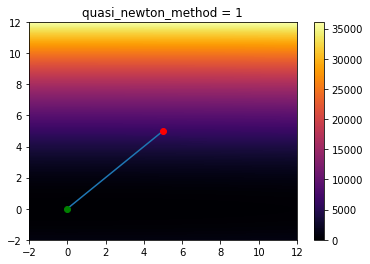

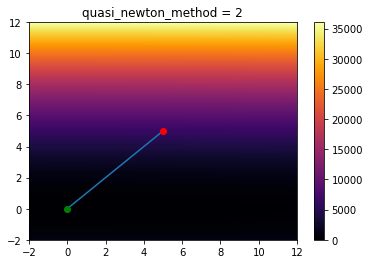

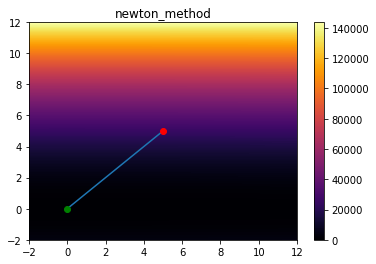

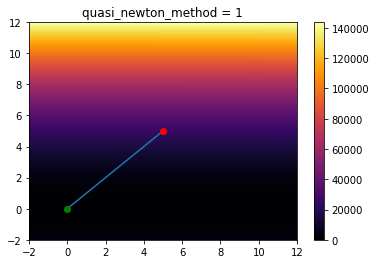

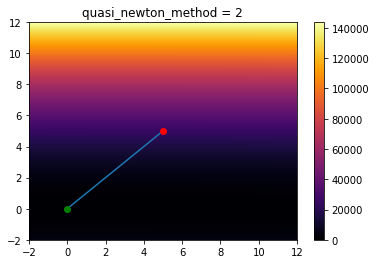

eps =  0.001


,newton_method,quasi_newton_method_1,quasi_newton_method_2
0,1,3,3
1,1,4,4
2,1,4,4


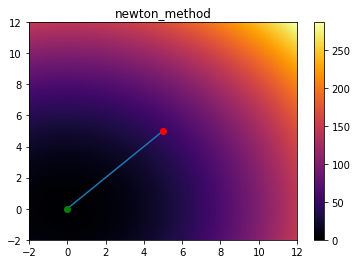

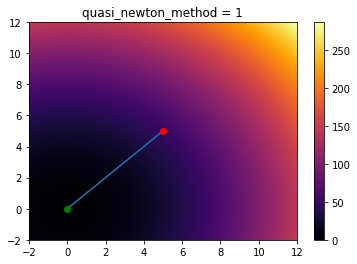

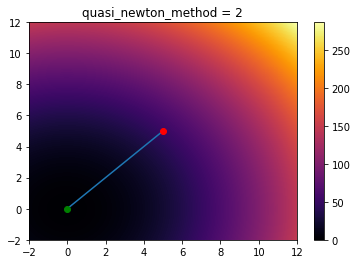

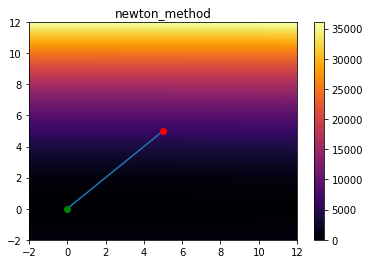

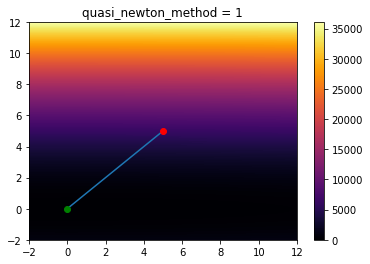

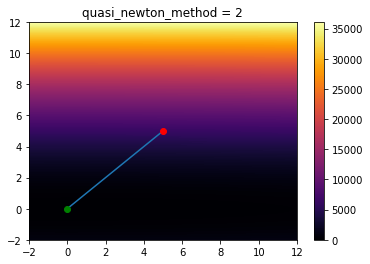

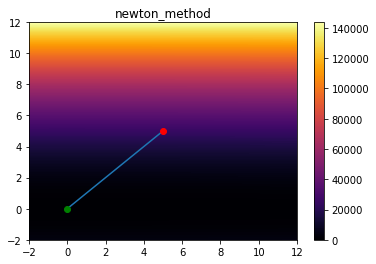

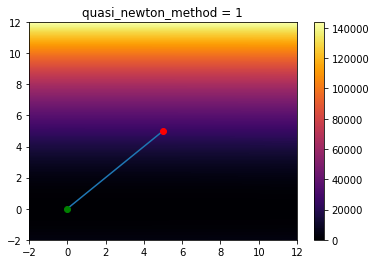

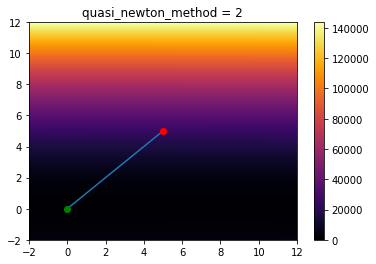

eps =  1e-05


,newton_method,quasi_newton_method_1,quasi_newton_method_2
0,1,3,3
1,1,3,3
2,1,3,3


In [7]:
start = [[5], [5]]

for eps in [10**(-3), 10**(-5)]:
    df = pd.DataFrame(columns=['newton_method', 'quasi_newton_method_1', 'quasi_newton_method_2'])

    for a in [1, 250, 1000]:
        f, grad_f, H_f = create_lambdas([x0, x1], x0**2 + a * x1**2)
        
        f_min1, x_min1, k_min1 = newton_method(f, grad_f, H_f, eps, start, 7)
        f_min2, x_min2, k_min2 = quasi_newton_method(f, grad_f, np.linalg.inv(H_f(start[0][0], start[1][0])), eps, start, 1, 7)
        f_min3, x_min3, k_min3 = quasi_newton_method(f, grad_f, np.linalg.inv(H_f(start[0][0], start[1][0])), eps, start, 2, 7)
        
        df = df.append(
            {
                'newton_method':k_min1, 
                'quasi_newton_method_1':k_min2, 
                'quasi_newton_method_2':k_min3
            }, ignore_index=True)
        
        
    print('eps = ', eps)
    display(df)

# Задание 4

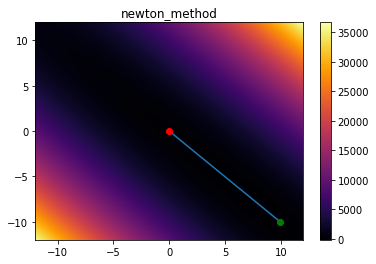

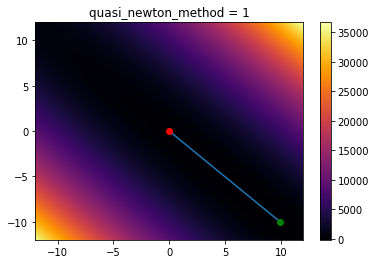

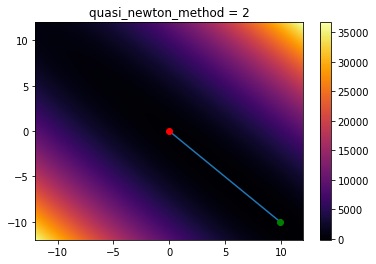

eps =  0.001


,newton_method,quasi_newton_method_1,quasi_newton_method_2
0,1,3,3


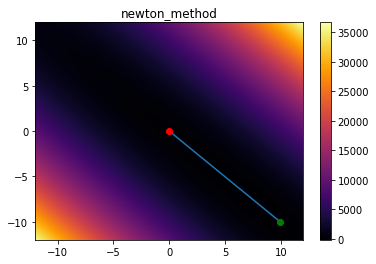

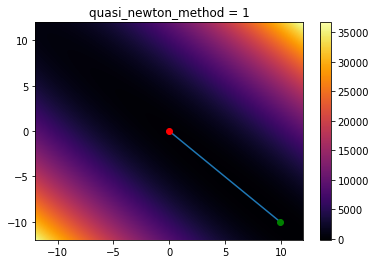

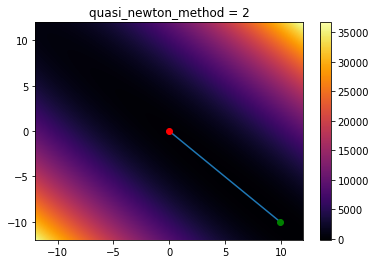

eps =  1e-05


,newton_method,quasi_newton_method_1,quasi_newton_method_2
0,1,3,3


In [8]:
start = [[0], [0]]

for eps in [10**(-3), 10**(-5)]:
    df = pd.DataFrame(columns=['newton_method', 'quasi_newton_method_1', 'quasi_newton_method_2'])

    for a in [250]:
        f, grad_f, H_f = create_lambdas([x0, x1], 64*x0**2+126*x0*x1+64*x1**2-10*x0+30*x1+13)
        
        f_min1, x_min1, k_min1 = newton_method(f, grad_f, H_f, eps, start, 12)
        f_min2, x_min2, k_min2 = quasi_newton_method(f, grad_f, np.linalg.inv(H_f(start[0][0], start[1][0])), eps, start, 1, 12)
        f_min3, x_min3, k_min3 = quasi_newton_method(f, grad_f, np.linalg.inv(H_f(start[0][0], start[1][0])), eps, start, 2, 12)
        
        df = df.append(
            {
                'newton_method':k_min1, 
                'quasi_newton_method_1':k_min2, 
                'quasi_newton_method_2':k_min3
            }, ignore_index=True)
        
        
    print('eps = ', eps)
    display(df)

# Задание 5

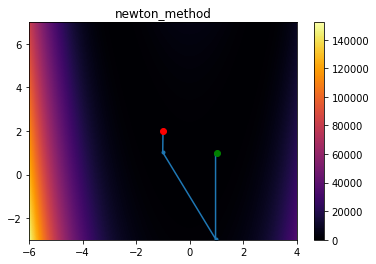

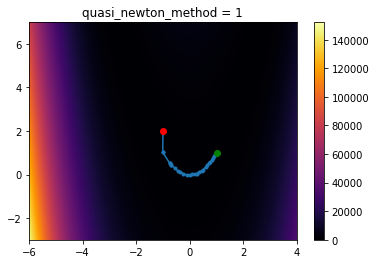

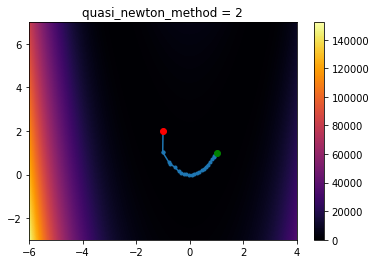

eps =  0.001


,newton_method,quasi_newton_method_1,quasi_newton_method_2
0,5,32,29


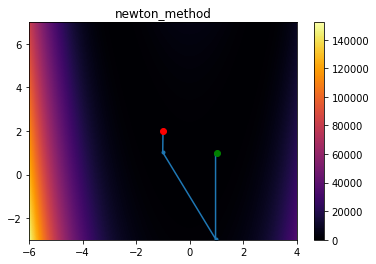

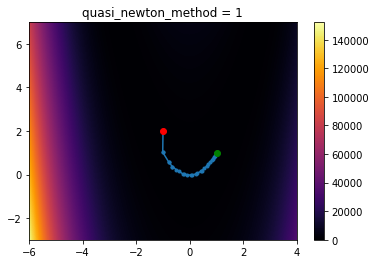

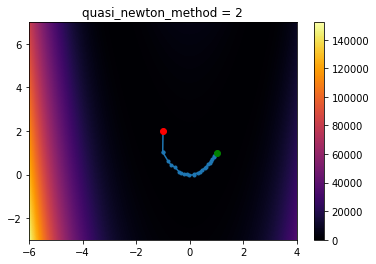

eps =  1e-05


,newton_method,quasi_newton_method_1,quasi_newton_method_2
0,5,33,32


In [9]:
start = [[-1], [2]]

for eps in [10**(-3), 10**(-5)]:
    df = pd.DataFrame(columns=['newton_method', 'quasi_newton_method_1', 'quasi_newton_method_2'])

    for a in [250]:
        f, grad_f, H_f = create_lambdas([x0, x1], 100*(x0**2-x1)**2+(x0-1)**2)
        
        f_min1, x_min1, k_min1 = newton_method(f, grad_f, H_f, eps, start, 5)
        f_min2, x_min2, k_min2 = quasi_newton_method(f, grad_f, np.linalg.inv(H_f(start[0][0], start[1][0])), eps, start, 1, 5)
        f_min3, x_min3, k_min3 = quasi_newton_method(f, grad_f, np.linalg.inv(H_f(start[0][0], start[1][0])), eps, start, 2, 5)
        
        df = df.append(
            {
                'newton_method':k_min1, 
                'quasi_newton_method_1':k_min2, 
                'quasi_newton_method_2':k_min3
            }, ignore_index=True)
        
        
    print('eps = ', eps)
    display(df)

# Задание 7

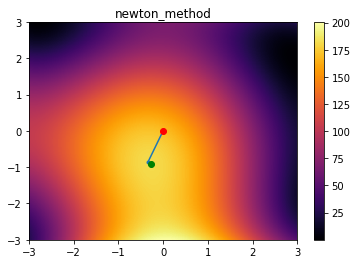

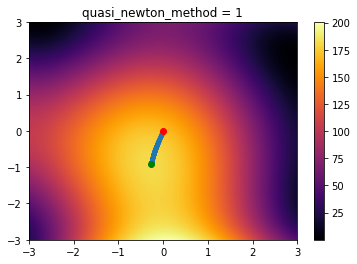

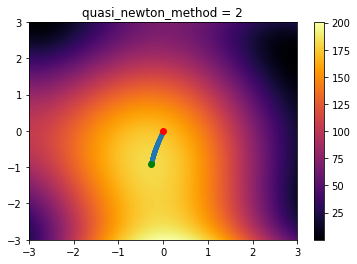

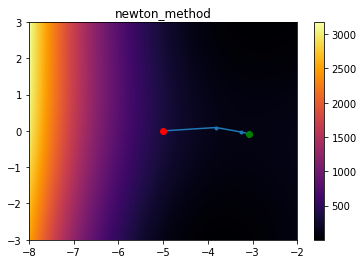

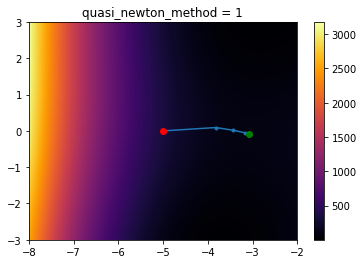

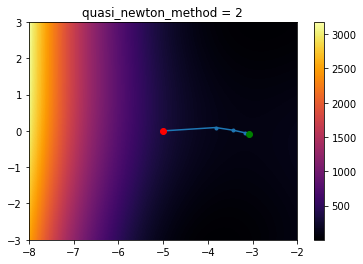

eps =  0.01


,newton_method,quasi_newton_method_1,quasi_newton_method_2
0,3,1194,1194
1,4,7,7


In [10]:
for eps in [10**(-2)]:
    df = pd.DataFrame(columns=['newton_method', 'quasi_newton_method_1', 'quasi_newton_method_2'])

    for start in [[[0], [0]], [[-5], [0]]]:
        f, grad_f, H_f = create_lambdas([x0, x1], (x0**2+x1-11)**2 + (x0 + x1**2 - 7)**2)
        
        f_min1, x_min1, k_min1 = newton_method(f, grad_f, H_f, eps, start, 3)
        f_min2, x_min2, k_min2 = quasi_newton_method(f, grad_f, np.linalg.inv(H_f(start[0][0], start[1][0])), eps, start, 1, 3)
        f_min3, x_min3, k_min3 = quasi_newton_method(f, grad_f, np.linalg.inv(H_f(start[0][0], start[1][0])), eps, start, 2, 3)
        
        df = df.append(
            {
                'newton_method':k_min1, 
                'quasi_newton_method_1':k_min2, 
                'quasi_newton_method_2':k_min3
            }, ignore_index=True)
        
        
    print('eps = ', eps)
    display(df)